In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale=1/255.)
validation_image_generator = ImageDataGenerator(rescale=1/255.)
test_image_generator = ImageDataGenerator(rescale=1/255.)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    class_mode="categorical")

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    class_mode="categorical")

test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'],  # No class labels for test data
    shuffle=False  # Maintain order for test predictions
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


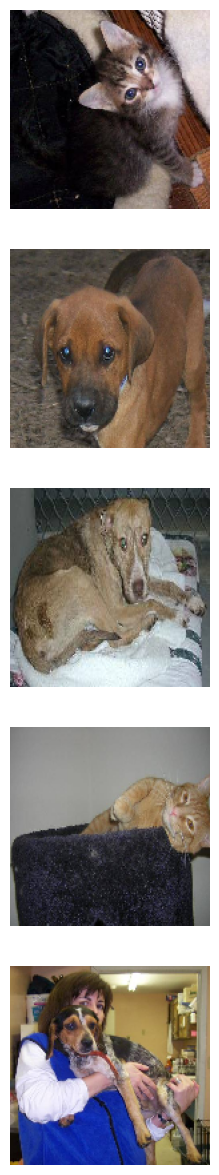

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
# Define data augmentation parameters


train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift up to 20% of image width
    height_shift_range=0.2,  # Random vertical shift up to 20% of image height
    shear_range=0.2,  # Random shear transformation up to 20%
    zoom_range=0.2,  # Random zoom up to 20%
    horizontal_flip=True  # Random horizontal flip
)



Found 2000 images belonging to 2 classes.


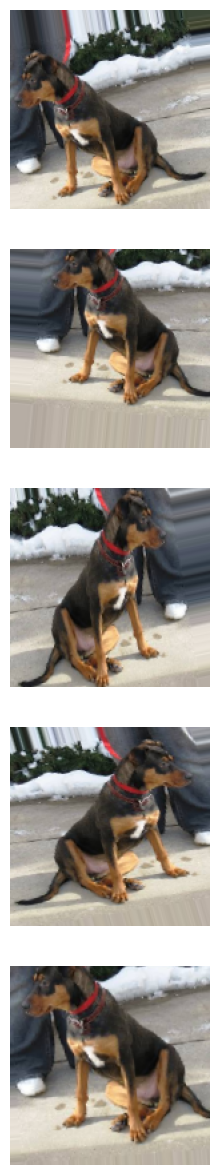

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [63]:
# 7
regularizer = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-5)

'''
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer))
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizer))
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(1, activation='sigmoid'))
'''

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer ,input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])





model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 dropout_11 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 34, 34, 128)     

In [64]:
# 8
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

Epoch 1/15
15/15 [==============================] - 17s 1s/step - loss: 1.3969 - accuracy: 0.5005 - val_loss: 0.7209 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 15s 1s/step - loss: 0.7184 - accuracy: 0.5310 - val_loss: 0.7178 - val_accuracy: 0.5000
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.7141 - accuracy: 0.5395 - val_loss: 0.7173 - val_accuracy: 0.5000
Epoch 4/15
15/15 [==============================] - 16s 1s/step - loss: 0.6953 - accuracy: 0.5694 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 5/15
15/15 [==============================] - 16s 1s/step - loss: 0.6843 - accuracy: 0.5833 - val_loss: 0.7190 - val_accuracy: 0.5000
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.6898 - accuracy: 0.5988 - val_loss: 0.7270 - val_accuracy: 0.5000
Epoch 7/15
15/15 [==============================] - 16s 1s/step - loss: 0.6669 - accuracy: 0.6052 - val_loss: 0.7238 - val_accuracy: 0.5000
Epoch 8/15
15/15 [==

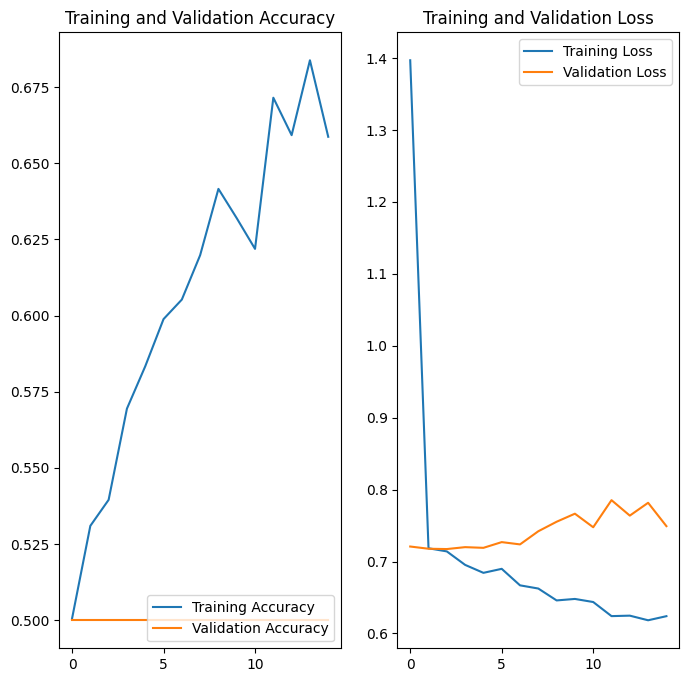

In [65]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 0s 27ms/step


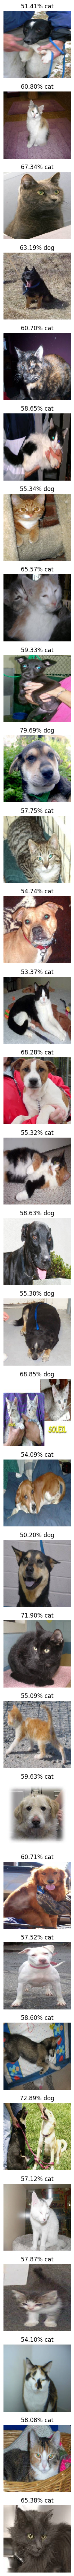

In [66]:
#10
test_data_gen.reset()  # Reset generator in case it was used for training before
predictions = model.predict(test_data_gen)

# Convert predictions to probabilities for cat class (assuming binary classification)
probabilities = predictions[:, 0]  # Assuming first column is probability of cat

# Get test images (modify if your test_data_gen provides images differently)
test_images = test_data_gen.next()[0]  # Assuming first element is image batch

# Visualize test images with predicted probabilities
plotImages(test_images, probabilities)



In [67]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
